In [1]:
from transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils

In [2]:
import matplotlib.pyplot as plt

def imshow(im, title=None):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

## 1. Edge Detection

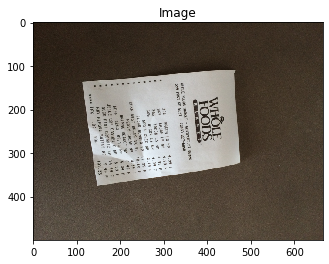

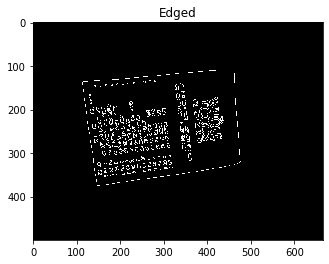

In [3]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread('receipt.jpg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
imshow(image, 'Image')
imshow(edged, 'Edged')

## 2. Find contours of paper

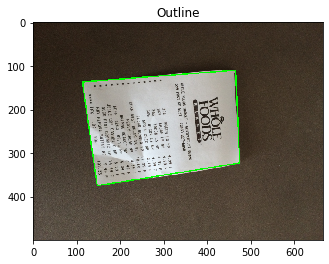

In [4]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

# show the contour (outline) of the piece of paper
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
imshow(image, 'Outline')

## 3. Apply perspective transform

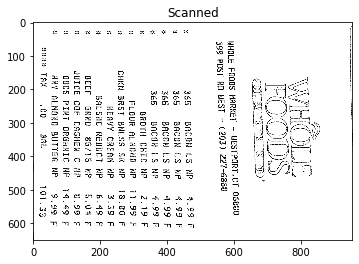

In [5]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = 'gaussian')
warped = (warped > T).astype('uint8') * 255

# show the original and scanned images
cv2.imshow('Original', imutils.resize(orig, height = 650))
imshow(imutils.resize(warped, height = 650), 'Scanned')